# FFTによるスペクトル解析
他の信号成分と周波数分離が可能な場合に、目的の周波数成分の強度を補正する方法について検討します。

まずは、、
- fo = 20Hz
- A = 1.0

の信号を、
- fs = 100kHz
- N = 2^15

でサンプリングした信号をＦＦＴかけた結果で確認します。

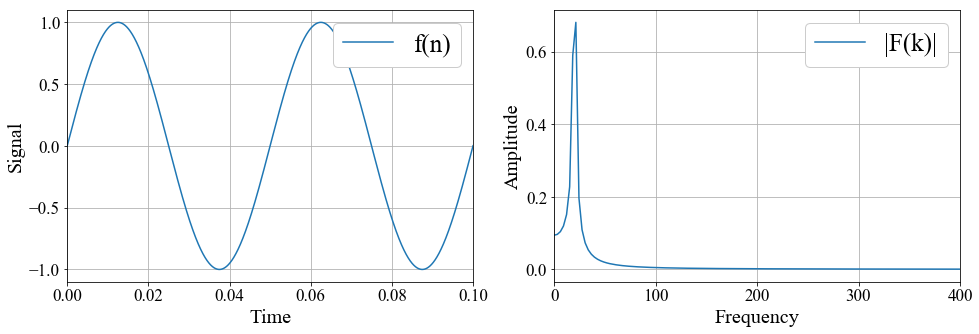

0.6811547247596914


In [109]:
import numpy as np
import matplotlib.pyplot as plt
import math
import numpy as np
from scipy.fftpack import fft, fftfreq
from scipy import hamming

from tkinter import filedialog

def fft(N,dt,sig,fo):
    # データのパラメータ
    t = np.arange(0, N*dt, dt) # 時間軸
    freq = np.linspace(0, 1.0/dt, N) # 周波数軸

    # 高速フーリエ変換
    F = np.fft.fft(sig)

    # 振幅スペクトルを計算
    Amp = np.abs(F/(N/2))

    # グラフ表示
    # グラフサイズを変更しておく
    plt.figure(figsize=(16, 5))
    plt.rcParams['font.family'] = 'Times New Roman'
    plt.rcParams['font.size'] = 17
    plt.subplot(121)
    plt.plot(t, sig, label='f(n)')
    plt.xlabel("Time", fontsize=20)
    plt.ylabel("Signal", fontsize=20)
    plt.xlim([0,0.1])
    plt.grid()
    leg = plt.legend(loc=1, fontsize=25)
    leg.get_frame().set_alpha(1)
    plt.subplot(122)
    plt.plot(freq, Amp, label='|F(k)|')
    plt.xlabel('Frequency', fontsize=20)
    plt.ylabel('Amplitude', fontsize=20)
    plt.xlim([0,400])
    plt.grid()
    leg = plt.legend(loc=1, fontsize=25)
    leg.get_frame().set_alpha(1)
    plt.show()
    return max(Amp)
    
def main():
    # file選択
    M = 32768
    ofs = 0.0
    y = [0 for i in range(M)]
    fs = 100000.0
    fo = 20.0
    for i in range(M):
        y[i] = 1.0 * math.sin( 2.0 * 3.1415926 * fo * float(i) / fs ) + ofs
    # list型からndarray型に変換する。
    y = np.array(y)
    res = fft(M,1e-5,y,fo)
    print(res)

if __name__ == "__main__":
    main()        
   

振幅１.0の信号を入れているにも関わらず、ＦＦＴにかけた結果は0.68と一致しない。
入力信号の周波数により測定区間での連続性が失われることにより、この差が発生します。
ＦＦＴの結果を補正して、振幅を取得する方法を検討します

## 評価方法
測定対象の信号の周波数を変えながら、入力信号振幅とＦＦＴの結果得られる信号レベルについて確認します。

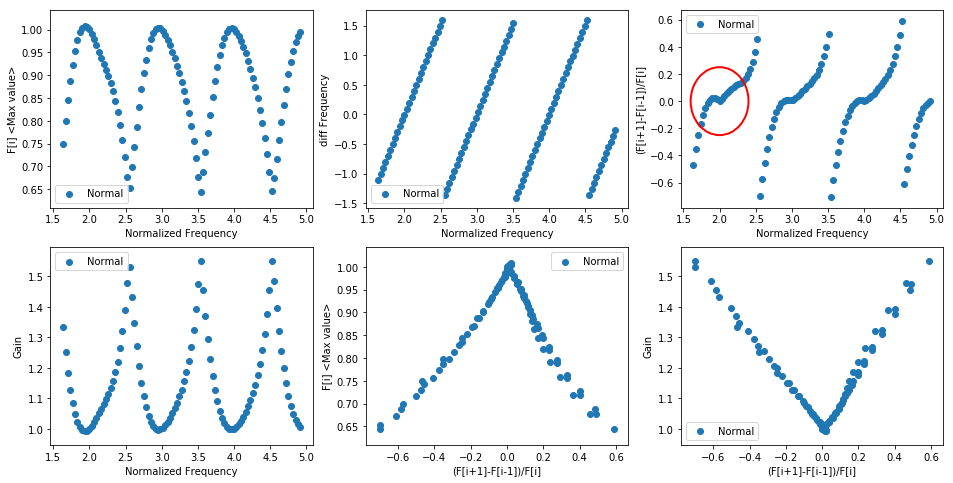

In [58]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import math
import numpy as np
from scipy.fftpack import fft, fftfreq
from scipy import signal

from tkinter import filedialog

def fft(N,dt,sig,f0):
    # データのパラメータ
    fs = 1.0/dt
    t = np.arange(0, N*dt, dt) # 時間軸
    freq = np.linspace(0, 1.0/dt, N) # 周波数軸

    # 高速フーリエ変換
    F = np.fft.fft(sig)
    mx = max(F)
    # print( abs(mx))
    # 振幅スペクトルを計算
    Amp = np.abs(F/(N/2))
    mx = 0    # max value
    mp = 0    # max position
    i = 0
    for a in Amp:
        if ( mx < a ):
            mx = a
            mp = i
        i = i + 1
    fx = mp * fs / float(N)
    dAmp = (Amp[mp+1] - Amp[mp-1]) / Amp[mp]
    df = f0 - fx
    Gain = 1.0 / Amp[mp]
    return( [ max(Amp[1:]), mp, fx, Amp[mp-1], Amp[mp], Amp[mp+1], dAmp, df, Gain ] )
    
def main():
    # file選択
    lc = 0
    N = 32768
    M = 32768
    ofs = 0.0
    y = [0 for i in range(M)]
    fin = np.linspace(0, 10, 101) # 周波数（入力信号）
    fr = np.linspace(0, 10, 101) # 周波数（測定結果）
    df = np.linspace(0, 10, 101) # 周波数（差）
    Pk = np.linspace(0, 10, 101) # 振幅（検出値）
    dA = np.linspace(0, 10, 101) # ( F(mp+1) - F(mp-1) ) / F(mp)
    Ga = np.linspace(0, 10, 101) # 補正ゲイン
    fs = 100000.0
    for j in range(101):
        for i in range(M):
            f = float(j) / 10.0 + 5.0
            y[i] = 1.0 * math.sin( 2.0 * 3.1415926 * f * float(i) / fs ) + ofs
        # list型からndarray型に変換する。
        y = np.array(y)
        res = fft(M,1e-5,y,f)
        for i in range(10):
            # print( "{0:7.3f}".format(res[i])+", ", end='')
            pass
        fin[j] = f / fs * float(N)
        fr[j] = res[2]+res[7]
        df[j] = res[7]
        Pk[j] = res[4]
        dA[j] = res[6]
        Ga[j] = res[8]
        # print()

    # プロット
    plt.figure(figsize=(16, 8))
#    plt.plot(dA, Ga, label='|F(k)|')
    plt.subplot(231)
    plt.scatter(fin,Pk)
    plt.axis("tight")
    plt.xlabel("Normalized Frequency")
    plt.ylabel("F[i] <Max value>")
    plt.legend(["Normal"])
    
    plt.subplot(232)
    plt.scatter(fin,df)
    plt.axis("tight")
    plt.xlabel("Normalized Frequency")
    plt.ylabel("diff Frequency")
    plt.legend(["Normal"])
    
    ax = plt.subplot(233)
    plt.scatter(fin,dA)
    plt.axis("tight")
    plt.xlabel("Normalized Frequency")
    plt.ylabel("(F[i+1]-F[i-1])/F[i]")
    plt.legend(["Normal"])
    c1 = mpatches.Arc(xy=(2.0,0.0),width=0.8, height=0.5, angle=0,theta1=0,theta2=360,linewidth=2,color='red')
    ax.add_patch(c1)
    
    plt.subplot(234)
    plt.scatter(fin,Ga)
    plt.axis("tight")
    plt.xlabel("Normalized Frequency")
    plt.ylabel("Gain")
    plt.legend(["Normal"])

    plt.subplot(235)
    plt.scatter(dA,Pk)
    plt.axis("tight")
    plt.xlabel("(F[i+1]-F[i-1])/F[i]")
    plt.ylabel("F[i] <Max value>")
    plt.legend(["Normal"])

    plt.subplot(236)
    plt.scatter(dA,Ga)
    plt.axis("tight")
    plt.xlabel("(F[i+1]-F[i-1])/F[i]")
    plt.ylabel("Gain")
    plt.legend(["Normal"])

    plt.show()
        
        
if __name__ == "__main__":
    main()        

計算の都合上、裾の振幅レベルを使用しているため、DCレベルの影響を避けるため2周期以上の信号を入力する必要がある。信号を２周期以上に限定した結果を下記に示す。

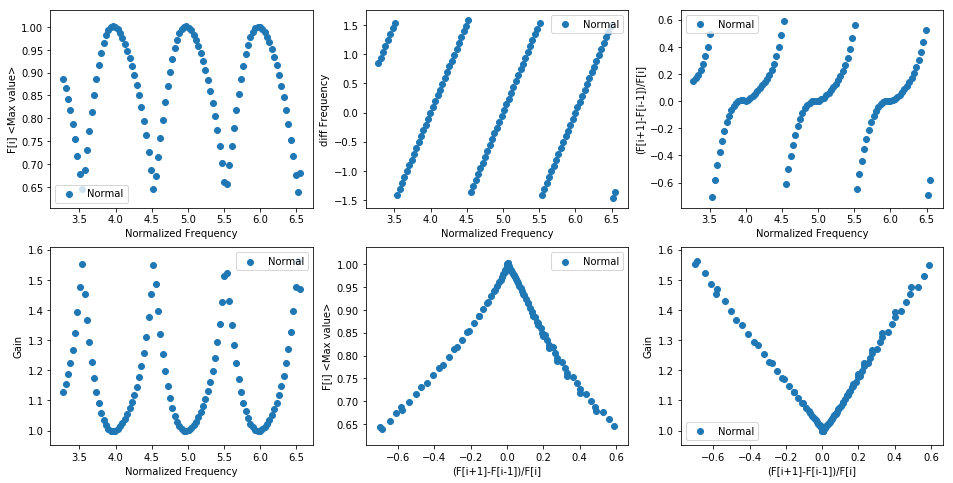

In [59]:
import numpy as np
import matplotlib.pyplot as plt
import math
import numpy as np
from scipy.fftpack import fft, fftfreq
from scipy import signal

from tkinter import filedialog

def fft(N,dt,sig,f0):
    # データのパラメータ
    fs = 1.0/dt
    t = np.arange(0, N*dt, dt) # 時間軸
    freq = np.linspace(0, 1.0/dt, N) # 周波数軸

    # 高速フーリエ変換
    F = np.fft.fft(sig)
    mx = max(F)
    # print( abs(mx))
    # 振幅スペクトルを計算
    Amp = np.abs(F/(N/2))
    mx = 0    # max value
    mp = 0    # max position
    i = 0
    for a in Amp:
        if ( mx < a ):
            mx = a
            mp = i
        i = i + 1
    fx = mp * fs / float(N)
    dAmp = (Amp[mp+1] - Amp[mp-1]) / Amp[mp]
    df = f0 - fx
    Gain = 1.0 / Amp[mp]
    return( [ max(Amp[1:]), mp, fx, Amp[mp-1], Amp[mp], Amp[mp+1], dAmp, df, Gain ] )
    
def main():
    # file選択
    lc = 0
    N = 32768
    M = 32768
    ofs = 0.0
    y = [0 for i in range(M)]
    fin = np.linspace(0, 10, 101) # 周波数（入力信号）
    fr = np.linspace(0, 10, 101) # 周波数（測定結果）
    df = np.linspace(0, 10, 101) # 周波数（差）
    Pk = np.linspace(0, 10, 101) # 振幅（検出値）
    dA = np.linspace(0, 10, 101) # ( F(mp+1) - F(mp-1) ) / F(mp)
    Ga = np.linspace(0, 10, 101) # 補正ゲイン
    fs = 100000.0
    for j in range(101):
        for i in range(M):
            f = float(j) / 10.0 + 6.3
            y[i] = 1.0 * math.sin( 2.0 * 3.1415926 * f * float(i) / fs ) + ofs
        # list型からndarray型に変換する。
        y = np.array(y)
        res = fft(M,1e-5,y,f)
        for i in range(10):
            # print( "{0:7.3f}".format(res[i])+", ", end='')
            pass
        fin[j] = f / fs * float(N)
        fr[j] = res[2]+res[7]
        df[j] = res[7]
        Pk[j] = res[4]
        dA[j] = res[6]
        Ga[j] = res[8]
        # print()

    # プロット
    plt.figure(figsize=(16, 8))
#    plt.plot(dA, Ga, label='|F(k)|')
    plt.subplot(231)
    plt.scatter(fin,Pk)
    plt.axis("tight")
    plt.xlabel("Normalized Frequency")
    plt.ylabel("F[i] <Max value>")
    plt.legend(["Normal"])
    
    plt.subplot(232)
    plt.scatter(fin,df)
    plt.axis("tight")
    plt.xlabel("Normalized Frequency")
    plt.ylabel("diff Frequency")
    plt.legend(["Normal"])
    
    plt.subplot(233)
    plt.scatter(fin,dA)
    plt.axis("tight")
    plt.xlabel("Normalized Frequency")
    plt.ylabel("(F[i+1]-F[i-1])/F[i]")
    plt.legend(["Normal"])

    plt.subplot(234)
    plt.scatter(fin,Ga)
    plt.axis("tight")
    plt.xlabel("Normalized Frequency")
    plt.ylabel("Gain")
    plt.legend(["Normal"])

    plt.subplot(235)
    plt.scatter(dA,Pk)
    plt.axis("tight")
    plt.xlabel("(F[i+1]-F[i-1])/F[i]")
    plt.ylabel("F[i] <Max value>")
    plt.legend(["Normal"])

    plt.subplot(236)
    plt.scatter(dA,Ga)
    plt.axis("tight")
    plt.xlabel("(F[i+1]-F[i-1])/F[i]")
    plt.ylabel("Gain")
    plt.legend(["Normal"])

    plt.show()
        
        
if __name__ == "__main__":
    main()        

多少はマシになりましたが、まだまだばらつきがあります。
不連続性を抑制するために窓関数を用いてみます。
使用する窓関数は、下記になります。

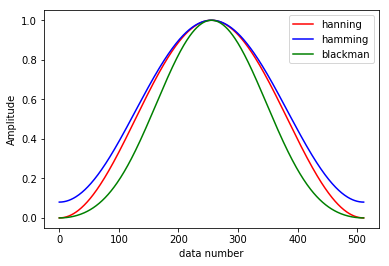

In [13]:
from scipy import signal
import matplotlib.pyplot as plt

# 時系列のサンプルデータ作成
N = 512                         # データ数

# 窓関数の一例
w1 = signal.hann(N)             # ハニング窓
w2 = signal.hamming(N)          # ハミング窓
w3 = signal.blackman(N)         # ブラックマン窓

# プロット
plt.figure()
plt.plot(w1, "r", w2, "b", w3, "g")
plt.axis("tight")
plt.ylabel("Amplitude")
plt.xlabel("data number")
plt.legend(["hanning", "hamming", "blackman"])
# plt.show()


## ハミング窓（signal.hamming)
まずは、ハミング窓について確認してみます。

[ 0.55836053 -0.00861378  1.85478489]


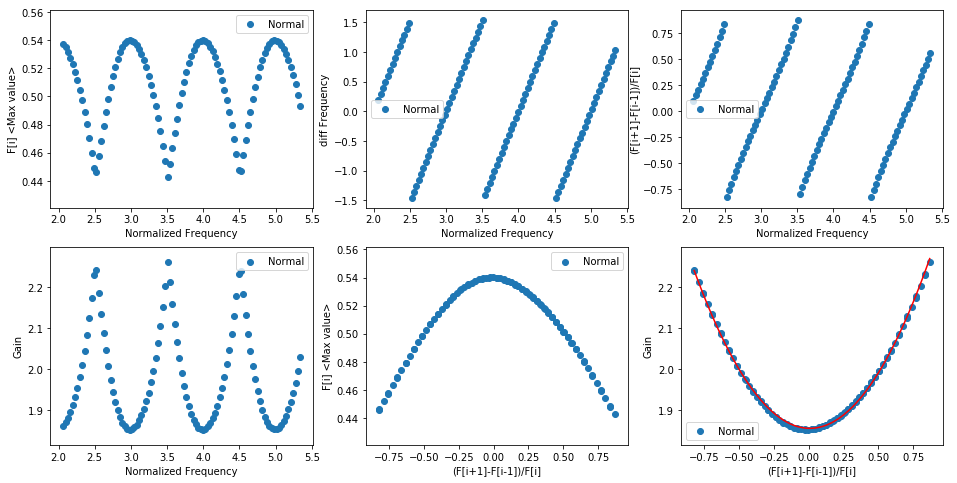

In [88]:
import numpy as np
import matplotlib.pyplot as plt
import math
import numpy as np
from scipy.fftpack import fft, fftfreq
from scipy import signal

from tkinter import filedialog

def fft(N,dt,sig,f0):
    # データのパラメータ
    fs = 1.0/dt
    t = np.arange(0, N*dt, dt) # 時間軸
    freq = np.linspace(0, 1.0/dt, N) # 周波数軸

    # 高速フーリエ変換
    F = np.fft.fft(sig)
    mx = max(F)
    # print( abs(mx))
    # 振幅スペクトルを計算
    Amp = np.abs(F/(N/2))
    mx = 0    # max value
    mp = 0    # max position
    i = 0
    for a in Amp:
        if ( mx < a ):
            mx = a
            mp = i
        i = i + 1
    fx = mp * fs / float(N)
    dAmp = (Amp[mp+1] - Amp[mp-1]) / Amp[mp]
    df = f0 - fx
    Gain = 1.0 / Amp[mp]
    return( [ max(Amp[1:]), mp, fx, Amp[mp-1], Amp[mp], Amp[mp+1], dAmp, df, Gain ] )
    
def main():
    # file選択
    lc = 0
    N = 32768
    M = 32768
    ofs = 0.0
    y = [0 for i in range(M)]
    fin = np.linspace(0, 10, 101) # 周波数（入力信号）
    fr = np.linspace(0, 10, 101) # 周波数（測定結果）
    df = np.linspace(0, 10, 101) # 周波数（差）
    Pk = np.linspace(0, 10, 101) # 振幅（検出値）
    dA = np.linspace(0, 10, 101) # ( F(mp+1) - F(mp-1) ) / F(mp)
    Ga = np.linspace(0, 10, 101) # 補正ゲイン
    x1 = np.linspace(0, 10, 101) # ( F(mp+1) - F(mp-1) ) / F(mp)
    y1 = np.linspace(0, 10, 101) # 補正ゲイン
    fs = 100000.0
    # window = signal.hann(N)       # ハニング窓
    window = signal.hamming(N)    # ハミング窓
    # window = signal.blackman(N)   # ブラックマン窓
    for j in range(101):
        for i in range(M):
            f = float(j) / 10.0 + 6.3
            y[i] = 1.0 * math.sin( 2.0 * 3.1415926 * f * float(i) / fs ) + ofs
        # list型からndarray型に変換する。
        y = np.array(y)
        windowed = window * y
        res = fft(M,1e-5,windowed,f)
        for i in range(10):
            # print( "{0:7.3f}".format(res[i])+", ", end='')
            pass
        fin[j] = f / fs * float(N)
        fr[j] = res[2]+res[7]
        df[j] = res[7]
        Pk[j] = res[4]
        dA[j] = res[6]
        Ga[j] = res[8]
        # print()

    # プロット
    plt.figure(figsize=(16, 8))
#    plt.plot(dA, Ga, label='|F(k)|')
    plt.subplot(231)
    plt.scatter(fin,Pk)
    plt.axis("tight")
    plt.xlabel("Normalized Frequency")
    plt.ylabel("F[i] <Max value>")
    plt.legend(["Normal"])
    
    plt.subplot(232)
    plt.scatter(fin,df)
    plt.axis("tight")
    plt.xlabel("Normalized Frequency")
    plt.ylabel("diff Frequency")
    plt.legend(["Normal"])
    
    plt.subplot(233)
    plt.scatter(fin,dA)
    plt.axis("tight")
    plt.xlabel("Normalized Frequency")
    plt.ylabel("(F[i+1]-F[i-1])/F[i]")
    plt.legend(["Normal"])

    plt.subplot(234)
    plt.scatter(fin,Ga)
    plt.axis("tight")
    plt.xlabel("Normalized Frequency")
    plt.ylabel("Gain")
    plt.legend(["Normal"])

    plt.subplot(235)
    plt.scatter(dA,Pk)
    plt.axis("tight")
    plt.xlabel("(F[i+1]-F[i-1])/F[i]")
    plt.ylabel("F[i] <Max value>")
    plt.legend(["Normal"])

    plt.subplot(236)
    plt.scatter(dA,Ga)
    plt.axis("tight")
    plt.xlabel("(F[i+1]-F[i-1])/F[i]")
    plt.ylabel("Gain")
    plt.legend(["Normal"])
    a_index = np.argsort(dA)
    for i in range(len(a_index)):
        x1[i] = dA[a_index[i]]
        y1[i] = Ga[a_index[i]]
    plt.plot(x1, np.poly1d(np.polyfit(x1, y1, 2))(x1), label='d=2',color='red')
    pf = np.polyfit(x1,y1,2)
    print(pf)
    
    plt.show()
        
        
if __name__ == "__main__":
    main()        

## ハニング窓（signal.hann）
次はハニング窓を確認してみます。

[0.56495246 0.00303802 2.0002333 ]


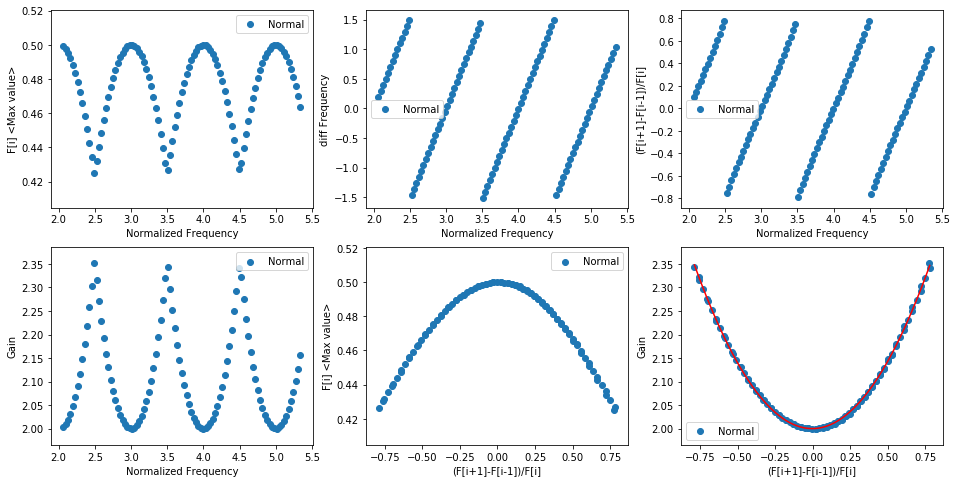

In [87]:
import numpy as np
import matplotlib.pyplot as plt
import math
import numpy as np
from scipy.fftpack import fft, fftfreq
from scipy import signal

from tkinter import filedialog

def fft(N,dt,sig,f0):
    # データのパラメータ
    fs = 1.0/dt
    t = np.arange(0, N*dt, dt) # 時間軸
    freq = np.linspace(0, 1.0/dt, N) # 周波数軸

    # 高速フーリエ変換
    F = np.fft.fft(sig)
    mx = max(F)
    # print( abs(mx))
    # 振幅スペクトルを計算
    Amp = np.abs(F/(N/2))
    mx = 0    # max value
    mp = 0    # max position
    i = 0
    for a in Amp:
        if ( mx < a ):
            mx = a
            mp = i
        i = i + 1
    fx = mp * fs / float(N)
    dAmp = (Amp[mp+1] - Amp[mp-1]) / Amp[mp]
    df = f0 - fx
    Gain = 1.0 / Amp[mp]
    return( [ max(Amp[1:]), mp, fx, Amp[mp-1], Amp[mp], Amp[mp+1], dAmp, df, Gain ] )
    
def main():
    # file選択
    lc = 0
    N = 32768
    M = 32768
    ofs = 0.0
    y = [0 for i in range(M)]
    fin = np.linspace(0, 10, 101) # 周波数（入力信号）
    fr = np.linspace(0, 10, 101) # 周波数（測定結果）
    df = np.linspace(0, 10, 101) # 周波数（差）
    Pk = np.linspace(0, 10, 101) # 振幅（検出値）
    dA = np.linspace(0, 10, 101) # ( F(mp+1) - F(mp-1) ) / F(mp)
    Ga = np.linspace(0, 10, 101) # 補正ゲイン
    x1 = np.linspace(0, 10, 101) # ( F(mp+1) - F(mp-1) ) / F(mp)
    y1 = np.linspace(0, 10, 101) # 補正ゲイン
    fs = 100000.0
    window = signal.hann(N)       # ハニング窓
    # window = signal.hamming(N)    # ハミング窓
    # window = signal.blackman(N)   # ブラックマン窓
    for j in range(101):
        for i in range(M):
            f = float(j) / 10.0 + 6.3
            y[i] = 1.0 * math.sin( 2.0 * 3.1415926 * f * float(i) / fs ) + ofs
        # list型からndarray型に変換する。
        y = np.array(y)
        windowed = window * y
        res = fft(M,1e-5,windowed,f)
        for i in range(10):
            # print( "{0:7.3f}".format(res[i])+", ", end='')
            pass
        fin[j] = f / fs * float(N)
        fr[j] = res[2]+res[7]
        df[j] = res[7]
        Pk[j] = res[4]
        dA[j] = res[6]
        Ga[j] = res[8]
        # print()

    # プロット
    plt.figure(figsize=(16, 8))
#    plt.plot(dA, Ga, label='|F(k)|')
    plt.subplot(231)
    plt.scatter(fin,Pk)
    plt.axis("tight")
    plt.xlabel("Normalized Frequency")
    plt.ylabel("F[i] <Max value>")
    plt.legend(["Normal"])
    
    plt.subplot(232)
    plt.scatter(fin,df)
    plt.axis("tight")
    plt.xlabel("Normalized Frequency")
    plt.ylabel("diff Frequency")
    plt.legend(["Normal"])
    
    plt.subplot(233)
    plt.scatter(fin,dA)
    plt.axis("tight")
    plt.xlabel("Normalized Frequency")
    plt.ylabel("(F[i+1]-F[i-1])/F[i]")
    plt.legend(["Normal"])

    plt.subplot(234)
    plt.scatter(fin,Ga)
    plt.axis("tight")
    plt.xlabel("Normalized Frequency")
    plt.ylabel("Gain")
    plt.legend(["Normal"])

    plt.subplot(235)
    plt.scatter(dA,Pk)
    plt.axis("tight")
    plt.xlabel("(F[i+1]-F[i-1])/F[i]")
    plt.ylabel("F[i] <Max value>")
    plt.legend(["Normal"])

    plt.subplot(236)
    plt.scatter(dA,Ga)
    plt.axis("tight")
    plt.xlabel("(F[i+1]-F[i-1])/F[i]")
    plt.ylabel("Gain")
    plt.legend(["Normal"])
    a_index = np.argsort(dA)
    for i in range(len(a_index)):
        x1[i] = dA[a_index[i]]
        y1[i] = Ga[a_index[i]]
    plt.plot(x1, np.poly1d(np.polyfit(x1, y1, 2))(x1), label='d=2',color='red')
    pf = np.polyfit(x1,y1,2)
    print(pf)
    plt.show()
        
        
if __name__ == "__main__":
    main()        

## ブラックマン窓（signal.blackman）
次はブラックマン窓を確認してみます。

[7.27449396e-01 1.13386091e-03 2.38113676e+00]


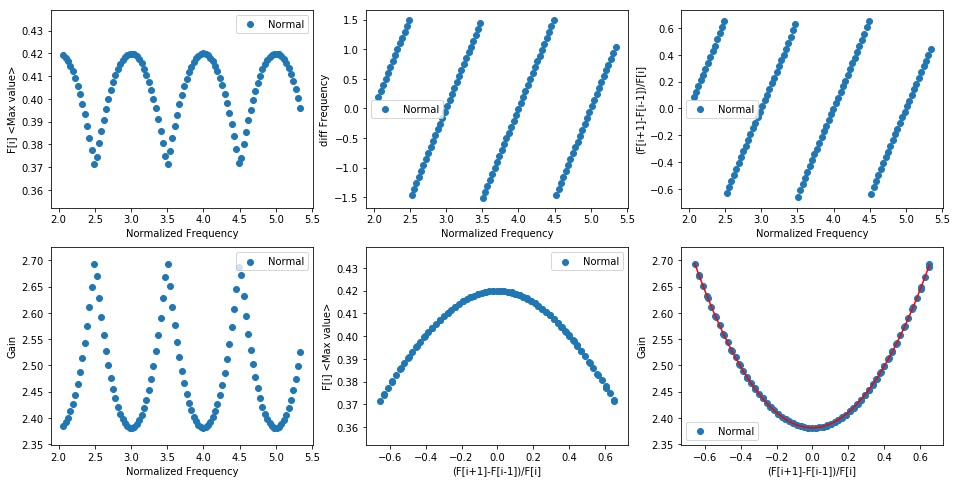

In [86]:
import numpy as np
import matplotlib.pyplot as plt
import math
import numpy as np
from scipy.fftpack import fft, fftfreq
from scipy import signal

from tkinter import filedialog

def fft(N,dt,sig,f0):
    # データのパラメータ
    fs = 1.0/dt
    t = np.arange(0, N*dt, dt) # 時間軸
    freq = np.linspace(0, 1.0/dt, N) # 周波数軸

    # 高速フーリエ変換
    F = np.fft.fft(sig)
    mx = max(F)
    # print( abs(mx))
    # 振幅スペクトルを計算
    Amp = np.abs(F/(N/2))
    mx = 0    # max value
    mp = 0    # max position
    i = 0
    for a in Amp:
        if ( mx < a ):
            mx = a
            mp = i
        i = i + 1
    fx = mp * fs / float(N)
    dAmp = (Amp[mp+1] - Amp[mp-1]) / Amp[mp]
    df = f0 - fx
    Gain = 1.0 / Amp[mp]
    return( [ max(Amp[1:]), mp, fx, Amp[mp-1], Amp[mp], Amp[mp+1], dAmp, df, Gain ] )
    
def main():
    # file選択
    lc = 0
    N = 32768
    M = 32768
    ofs = 0.0
    y = [0 for i in range(M)]
    fin = np.linspace(0, 10, 101) # 周波数（入力信号）
    fr = np.linspace(0, 10, 101) # 周波数（測定結果）
    df = np.linspace(0, 10, 101) # 周波数（差）
    Pk = np.linspace(0, 10, 101) # 振幅（検出値）
    dA = np.linspace(0, 10, 101) # ( F(mp+1) - F(mp-1) ) / F(mp)
    Ga = np.linspace(0, 10, 101) # 補正ゲイン
    x1 = np.linspace(0, 10, 101) # ( F(mp+1) - F(mp-1) ) / F(mp)
    y1 = np.linspace(0, 10, 101) # 補正ゲイン
    fs = 100000.0
    # window = signal.hann(N)       # ハニング窓
    # window = signal.hamming(N)    # ハミング窓
    window = signal.blackman(N)   # ブラックマン窓
    for j in range(101):
        for i in range(M):
            f = float(j) / 10.0 + 6.3
            y[i] = 1.0 * math.sin( 2.0 * 3.1415926 * f * float(i) / fs ) + ofs
        # list型からndarray型に変換する。
        y = np.array(y)
        windowed = window * y
        res = fft(M,1e-5,windowed,f)
        for i in range(10):
            # print( "{0:7.3f}".format(res[i])+", ", end='')
            pass
        fin[j] = f / fs * float(N)
        fr[j] = res[2]+res[7]
        df[j] = res[7]
        Pk[j] = res[4]
        dA[j] = res[6]
        Ga[j] = res[8]
        # print()

    # プロット
    plt.figure(figsize=(16, 8))
#    plt.plot(dA, Ga, label='|F(k)|')
    plt.subplot(231)
    plt.scatter(fin,Pk)
    plt.axis("tight")
    plt.xlabel("Normalized Frequency")
    plt.ylabel("F[i] <Max value>")
    plt.legend(["Normal"])
    
    plt.subplot(232)
    plt.scatter(fin,df)
    plt.axis("tight")
    plt.xlabel("Normalized Frequency")
    plt.ylabel("diff Frequency")
    plt.legend(["Normal"])
    
    plt.subplot(233)
    plt.scatter(fin,dA)
    plt.axis("tight")
    plt.xlabel("Normalized Frequency")
    plt.ylabel("(F[i+1]-F[i-1])/F[i]")
    plt.legend(["Normal"])

    plt.subplot(234)
    plt.scatter(fin,Ga)
    plt.axis("tight")
    plt.xlabel("Normalized Frequency")
    plt.ylabel("Gain")
    plt.legend(["Normal"])

    plt.subplot(235)
    plt.scatter(dA,Pk)
    plt.axis("tight")
    plt.xlabel("(F[i+1]-F[i-1])/F[i]")
    plt.ylabel("F[i] <Max value>")
    plt.legend(["Normal"])

    plt.subplot(236)
    plt.scatter(dA,Ga)
    plt.axis("tight")
    plt.xlabel("(F[i+1]-F[i-1])/F[i]")
    plt.ylabel("Gain")
    plt.legend(["Normal"])
    a_index = np.argsort(dA)
    for i in range(len(a_index)):
        x1[i] = dA[a_index[i]]
        y1[i] = Ga[a_index[i]]
    plt.plot(x1, np.poly1d(np.polyfit(x1, y1, 2))(x1), label='d=2',color='red')
    pf = np.polyfit(x1,y1,2)
    print(pf)

    plt.show()
        
        
if __name__ == "__main__":
    main()        

## 高域のノイズを加えた場合


[7.27455888e-01 1.15116920e-03 2.38113361e+00]


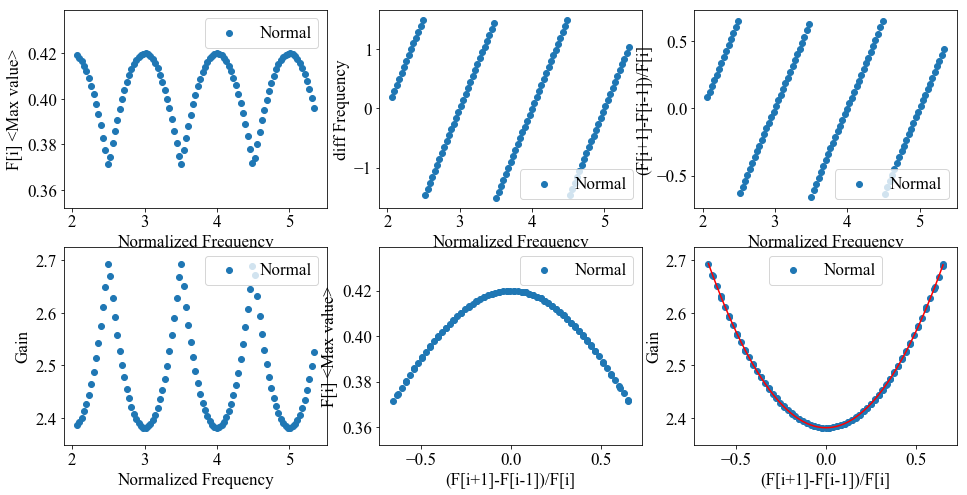

In [124]:
import numpy as np
import matplotlib.pyplot as plt
import math
import numpy as np
from scipy.fftpack import fft, fftfreq
from scipy import signal

from tkinter import filedialog

def fft(N,dt,sig,f0):
    # データのパラメータ
    fs = 1.0/dt
    t = np.arange(0, N*dt, dt) # 時間軸
    freq = np.linspace(0, 1.0/dt, N) # 周波数軸

    # 高速フーリエ変換
    F = np.fft.fft(sig)
    mx = max(F)
    # print( abs(mx))
    # 振幅スペクトルを計算
    Amp = np.abs(F/(N/2))
    mx = 0    # max value
    mp = 0    # max position
    i = 2
    for a in Amp[2:20]:
        if ( mx < a ):
            mx = a
            mp = i
        i = i + 1
    fx = mp * fs / float(N)
    dAmp = (Amp[mp+1] - Amp[mp-1]) / Amp[mp]
    df = f0 - fx
    Gain = 1.0 / Amp[mp]
    return( [ max(Amp[1:]), mp, fx, Amp[mp-1], Amp[mp], Amp[mp+1], dAmp, df, Gain ] )
    
def main():
    # file選択
    lc = 0
    N = 32768
    M = 32768
    ofs = 0.0
    y = [0 for i in range(M)]
    fin = np.linspace(0, 10, 101) # 周波数（入力信号）
    fr = np.linspace(0, 10, 101) # 周波数（測定結果）
    df = np.linspace(0, 10, 101) # 周波数（差）
    Pk = np.linspace(0, 10, 101) # 振幅（検出値）
    dA = np.linspace(0, 10, 101) # ( F(mp+1) - F(mp-1) ) / F(mp)
    Ga = np.linspace(0, 10, 101) # 補正ゲイン
    x1 = np.linspace(0, 10, 101) # ( F(mp+1) - F(mp-1) ) / F(mp)
    y1 = np.linspace(0, 10, 101) # 補正ゲイン
    fs = 100000.0
    # window = signal.hann(N)       # ハニング窓
    # window = signal.hamming(N)    # ハミング窓
    window = signal.blackman(N)   # ブラックマン窓
    for j in range(101):
        for i in range(M):
            f = float(j) / 10.0 + 6.3
            y[i] = 1.0 * math.sin( 2.0 * 3.1415926 * f * float(i) / fs ) + 1.0 * math.sin( 2.0 * 3.1415926 * 100 * float(i) / fs )
        # list型からndarray型に変換する。
        y = np.array(y)
        windowed = window * y
        res = fft(M,1e-5,windowed,f)
        for i in range(10):
            # print( "{0:7.3f}".format(res[i])+", ", end='')
            pass
        fin[j] = f / fs * float(N)
        fr[j] = res[2]+res[7]
        df[j] = res[7]
        Pk[j] = res[4]
        dA[j] = res[6]
        Ga[j] = res[8]
        # print()

    # プロット
    plt.figure(figsize=(16, 8))
#    plt.plot(dA, Ga, label='|F(k)|')
    plt.subplot(231)
    plt.scatter(fin,Pk)
    plt.axis("tight")
    plt.xlabel("Normalized Frequency")
    plt.ylabel("F[i] <Max value>")
    plt.legend(["Normal"])
    
    plt.subplot(232)
    plt.scatter(fin,df)
    plt.axis("tight")
    plt.xlabel("Normalized Frequency")
    plt.ylabel("diff Frequency")
    plt.legend(["Normal"])
    
    plt.subplot(233)
    plt.scatter(fin,dA)
    plt.axis("tight")
    plt.xlabel("Normalized Frequency")
    plt.ylabel("(F[i+1]-F[i-1])/F[i]")
    plt.legend(["Normal"])

    plt.subplot(234)
    plt.scatter(fin,Ga)
    plt.axis("tight")
    plt.xlabel("Normalized Frequency")
    plt.ylabel("Gain")
    plt.legend(["Normal"])

    plt.subplot(235)
    plt.scatter(dA,Pk)
    plt.axis("tight")
    plt.xlabel("(F[i+1]-F[i-1])/F[i]")
    plt.ylabel("F[i] <Max value>")
    plt.legend(["Normal"])

    plt.subplot(236)
    plt.scatter(dA,Ga)
    plt.axis("tight")
    plt.xlabel("(F[i+1]-F[i-1])/F[i]")
    plt.ylabel("Gain")
    plt.legend(["Normal"])
    a_index = np.argsort(dA)
    for i in range(len(a_index)):
        x1[i] = dA[a_index[i]]
        y1[i] = Ga[a_index[i]]
    plt.plot(x1, np.poly1d(np.polyfit(x1, y1, 2))(x1), label='d=2',color='red')
    pf = np.polyfit(x1,y1,2)
    print(pf)

    plt.show()
        
        
if __name__ == "__main__":
    main()        

周波数分離さえできていれば、補正結果には影響はでません

## ランダムノイズを加えた場合
信号レベルの同程度のノイズを加えた場合の特性について確認します。
- An: ノイズレベル（ランダムノイズ）
- Ao: 信号レベル
- A1: 高次ノイズ（発振周波数：f1）



[7.25924313e-01 1.14224721e-03 2.38131523e+00]


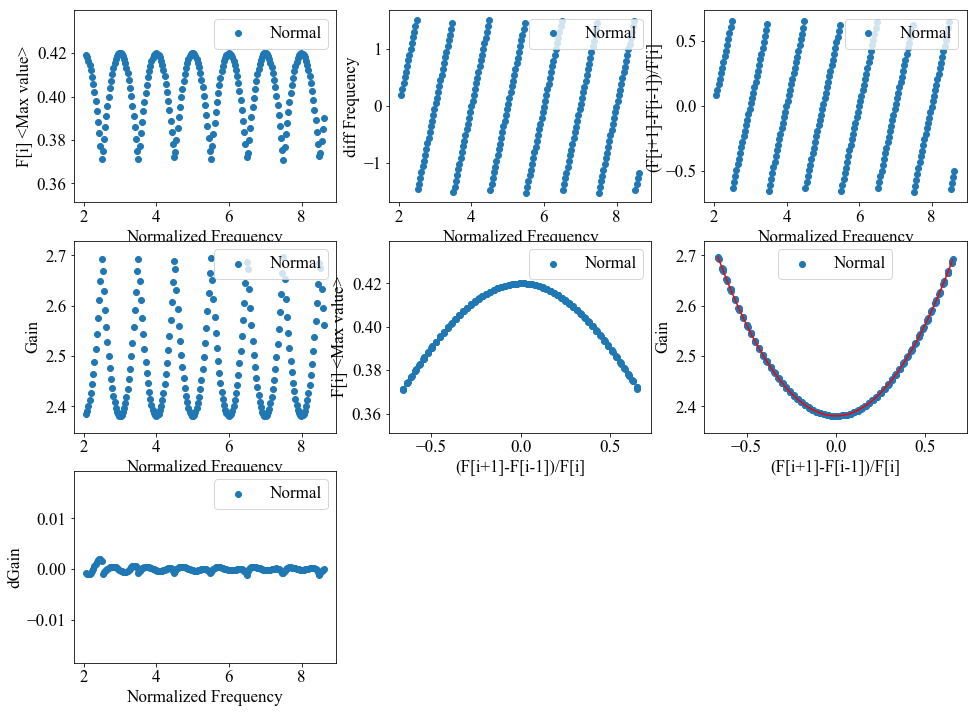

In [132]:
import numpy as np
import matplotlib.pyplot as plt
import math
import numpy as np
from scipy.fftpack import fft, fftfreq
from scipy import signal
from numpy.random import *

from tkinter import filedialog

def fft(N,dt,sig,f0):
    # データのパラメータ
    fs = 1.0/dt
    t = np.arange(0, N*dt, dt) # 時間軸
    freq = np.linspace(0, 1.0/dt, N) # 周波数軸

    # 高速フーリエ変換
    F = np.fft.fft(sig)
    mx = max(F)
    # print( abs(mx))
    # 振幅スペクトルを計算
    Amp = np.abs(F/(N/2))
    mx = 0    # max value
    mp = 0    # max position
    i = 2
    for a in Amp[2:12]:
        if ( mx < a ):
            mx = a
            mp = i
        i = i + 1
    fx = mp * fs / float(N)
    dAmp = (Amp[mp+1] - Amp[mp-1]) / Amp[mp]
    df = f0 - fx
    Gain = 1.0 / Amp[mp]
    return( [ max(Amp[1:]), mp, fx, Amp[mp-1], Amp[mp], Amp[mp+1], dAmp, df, Gain ] )
    
def main():
    # file選択
    lc = 0
    NN = 201
    N = 32768
    M = 32768
    ofs = 0.0
    Ao = 1.0
    An = 0.0
    A1 = 1.0
    f1 = 50.0
    y = [0 for i in range(M)]
    fin = np.linspace(0, 10, NN) # 周波数（入力信号）
    fr = np.linspace(0, 10, NN) # 周波数（測定結果）
    df = np.linspace(0, 10, NN) # 周波数（差）
    Pk = np.linspace(0, 10, NN) # 振幅（検出値）
    dA = np.linspace(0, 10, NN) # ( F(mp+1) - F(mp-1) ) / F(mp)
    Ga = np.linspace(0, 10, NN) # 補正ゲイン
    x1 = np.linspace(0, 10, NN) # ( F(mp+1) - F(mp-1) ) / F(mp)
    y1 = np.linspace(0, 10, NN) # 補正ゲイン
    dGa = np.linspace(0, 10, NN) # 補正ゲイン差
    fs = 100000.0
    # window = signal.hann(N)       # ハニング窓
    # window = signal.hamming(N)    # ハミング窓
    window = signal.blackman(N)   # ブラックマン窓
    for j in range(NN):
        for i in range(M):
            f = float(j) / 10.0 + 6.3
            y[i] = Ao * math.sin( 2.0 * 3.1415926 * f * float(i) / fs ) + A1 * math.sin( 2.0 * 3.1415926 * f1 * float(i) / fs )+An*(2.*rand()-1.)
            # list型からndarray型に変換する。
        y = np.array(y)
        windowed = window * y
        res = fft(M,1e-5,windowed,f)
        for i in range(10):
            # print( "{0:7.3f}".format(res[i])+", ", end='')
            pass
        fin[j] = f / fs * float(N)
        fr[j] = res[2]+res[7]
        df[j] = res[7]
        Pk[j] = res[4]
        dA[j] = res[6]
        Ga[j] = res[8]
        # print()

    # プロット
    plt.figure(figsize=(16, 12))
#    plt.plot(dA, Ga, label='|F(k)|')
    plt.subplot(331)
    plt.scatter(fin,Pk)
    plt.axis("tight")
    plt.xlabel("Normalized Frequency")
    plt.ylabel("F[i] <Max value>")
    plt.legend(["Normal"])
    
    plt.subplot(332)
    plt.scatter(fin,df)
    plt.axis("tight")
    plt.xlabel("Normalized Frequency")
    plt.ylabel("diff Frequency")
    plt.legend(["Normal"])
    
    plt.subplot(333)
    plt.scatter(fin,dA)
    plt.axis("tight")
    plt.xlabel("Normalized Frequency")
    plt.ylabel("(F[i+1]-F[i-1])/F[i]")
    plt.legend(["Normal"])

    plt.subplot(334)
    plt.scatter(fin,Ga)
    plt.axis("tight")
    plt.xlabel("Normalized Frequency")
    plt.ylabel("Gain")
    plt.legend(["Normal"])

    plt.subplot(335)
    plt.scatter(dA,Pk)
    plt.axis("tight")
    plt.xlabel("(F[i+1]-F[i-1])/F[i]")
    plt.ylabel("F[i] <Max value>")
    plt.legend(["Normal"])

    plt.subplot(336)
    plt.scatter(dA,Ga)
    plt.axis("tight")
    plt.xlabel("(F[i+1]-F[i-1])/F[i]")
    plt.ylabel("Gain")
    plt.legend(["Normal"])
    a_index = np.argsort(dA)
    for i in range(len(a_index)):
        x1[i] = dA[a_index[i]]
        y1[i] = Ga[a_index[i]]
    plt.plot(x1, np.poly1d(np.polyfit(x1, y1, 2))(x1), label='d=2',color='red')
    pf = np.polyfit(x1,y1,2)
    print(pf)
    
    for i in range(len(a_index)):
        dGa[i] = Ga[i] - ( pf[0] * dA[i] * dA[i] + pf[1] * dA[i] + pf[2] )
    
    plt.subplot(337)
    plt.scatter(fin,dGa)
    plt.axis("tight")
    plt.xlabel("Normalized Frequency")
    plt.ylabel("dGain")
    plt.legend(["Normal"])

    plt.show()
        
if __name__ == "__main__":
    main()        

同程度のランダムノイズ程度であれば、5%程度の誤差で検出することができそう。

http://www.ic.is.tohoku.ac.jp/~swk/lecture/yaruodsp/win.html

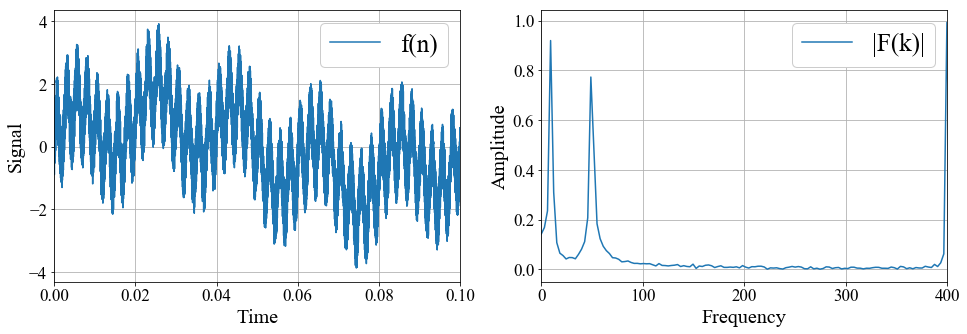

0.993348670261569


In [129]:
import numpy as np
import matplotlib.pyplot as plt
import math
import numpy as np
from scipy.fftpack import fft, fftfreq
from scipy import hamming

from tkinter import filedialog
from numpy.random import *

def fft(N,dt,sig,fo):
    # データのパラメータ
    t = np.arange(0, N*dt, dt) # 時間軸
    freq = np.linspace(0, 1.0/dt, N) # 周波数軸

    # 高速フーリエ変換
    F = np.fft.fft(sig)

    # 振幅スペクトルを計算
    Amp = np.abs(F/(N/2))

    # グラフ表示
    # グラフサイズを変更しておく
    plt.figure(figsize=(16, 5))
    plt.rcParams['font.family'] = 'Times New Roman'
    plt.rcParams['font.size'] = 17
    plt.subplot(121)
    plt.plot(t, sig, label='f(n)')
    plt.xlabel("Time", fontsize=20)
    plt.ylabel("Signal", fontsize=20)
    plt.xlim([0,0.1])
    plt.grid()
    leg = plt.legend(loc=1, fontsize=25)
    leg.get_frame().set_alpha(1)
    plt.subplot(122)
    plt.plot(freq, Amp, label='|F(k)|')
    plt.xlabel('Frequency', fontsize=20)
    plt.ylabel('Amplitude', fontsize=20)
    plt.xlim([0,400])
    plt.grid()
    leg = plt.legend(loc=1, fontsize=25)
    leg.get_frame().set_alpha(1)
    plt.show()
    return max(Amp)
    
def main():
    # file選択
    M = 32768
    An = 1.0
    A1 = 1.0
    A2 = 1.0
    ofs = 0.0
    y = [0 for i in range(M)]
    fs = 100000.0
    fo = 10.0
    f1 = 50.0
    f2 = 400.0
    for i in range(M):
        y[i] = 1.0 * math.sin( 2.0 * 3.1415926 * fo * float(i) / fs ) + A1 * math.sin( 2.0 * 3.1415926 * f1 * float(i) / fs )+An*(2*rand()-1)+ A2 * math.sin( 2.0 * 3.1415926 * f2 * float(i) / fs )
    # list型からndarray型に変換する。
    y = np.array(y)
    res = fft(M,1e-5,y,fo)
    print(res)

if __name__ == "__main__":
    main()        
   